In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import mpl_toolkits.axes_grid1 as plt_ax
import itertools
%matplotlib inline

def plot(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    plotted = None
    if enum:
        plotted = ax.plot(data)
    else:
        mapping = np.array(data).T
        plotted = ax.plot(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    return plotted

def scatter(ax, data, enum=False, title='', labels=None, legend=False, **kwargs):
    scattered = None
    if enum:
        scattered = ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        scattered = ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    ax.scatter(*np.mean(data, axis=0), color='red', s=40)
    return scattered

def plot_ridge(ridge):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(*ridge.T)
    ax1.set_xticks(ax1.get_xticks()[::2])
    ax1.set_yticks(ax1.get_yticks()[::2])
    ax1.set_zticks(ax1.get_zticks()[::2])
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('y')
    ax1.scatter(*ridge.mean(axis=0), color='red', s=70)
    ax2 = fig.add_subplot(132)
    scatter(ax2, ridge[:, [0, 2]], labels=['x1', 'y'])
    ax2.set_xticks(ax2.get_xticks()[::2])
    ax3 = fig.add_subplot(133)
    scatter(ax3, ridge[:, [1, 2]], labels=['x2', 'y'])
    fig.tight_layout()

def scatter_set(data1, data2, titles=['Training set', 'Validation set']):
    min_ = min(np.concatenate([data1[:, 2], data2[:, 2]]))
    max_ = max(np.concatenate([data1[:, 2], data2[:, 2]]))
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    for data, ax, title in zip([data1, data2], axes, titles):
        dataX = data[:, :2]
        dataY = data[:, 2]
        C = dataX.T.dot(dataX) / dataX.shape[0]
        _, ev = np.linalg.eigh(C)
        scatter_ax = scatter(ax, dataX, c=dataY, vmin=min_, vmax=max_, s=np.sqrt(dataY / max_) * 100, title=title)
        ax.arrow(0, 0, *ev[0], head_width=0.2, head_length=0.1, fc='k', ec='k')
        ax.arrow(0, 0, *ev[1], head_width=0.2, head_length=0.1, fc='k', ec='k')
    fig.subplots_adjust(right=0.85)
    fig.colorbar(scatter_ax, cmap='jet', cax=fig.add_axes([0.9, 0.15, 0.03, 0.7]))
    
def plot_heatmaps(monomials):
    powers = np.array([[0, 0], [1, 0], [0, 1], [2, 0], [1, 1], [0, 2], [3, 0], [2, 1], [1, 2], [0, 3]])
    fig, axes = plt.subplots(5, 2, figsize=(10, 16))
    for row, axesRow in enumerate(axes):
        print row,axesRow
        for col, ax in enumerate(axesRow):
            i = row * 2 + col
            max_ = 5  # monomials[i, :10].max()
            img = ax.imshow(monomials[i, :10].T, extent=[-40, 40, -35, 35], aspect='auto', vmin=-max_, vmax=max_)
            cax = plt_ax.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(img, cax=cax)
            ax.set_title(r'$degree = {}, \phi_{} = x_1^{} x_2^{}$'.format(powers[i].sum(), i, *powers[i]))
            ax.set_ylabel('x1')
            ax.set_xlabel('x2')
    fig.subplots_adjust(hspace=.4, wspace=.3)

def plot_mse(MSE, lambda_index='T'):
    fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    meanlineprops = dict(linestyle='--', linewidth=2.5, color='green')
    ax.boxplot(MSE.T, meanprops=meanlineprops, meanline=True, showmeans=True)
    ax.set_yscale('log')
    means = MSE.T.mean(axis=0)
    best_mse_index = np.argmin(means)
    ax.set_title(r'Boxplots for each lambda  -  $avg_{{min}} = {:.2f}$ at $\lambda_{} = 10^{{{:.1f}}}$'.format(
        means[best_mse_index], lambda_index, np.linspace(-4, 4, 81)[best_mse_index]))
    ax.grid(True)
    ax.set_xticks(ax.get_xticks()[::10])
    ax.set_xticklabels([r'$10^{{{}}}$'.format(x) for x in range(-4, 5)])

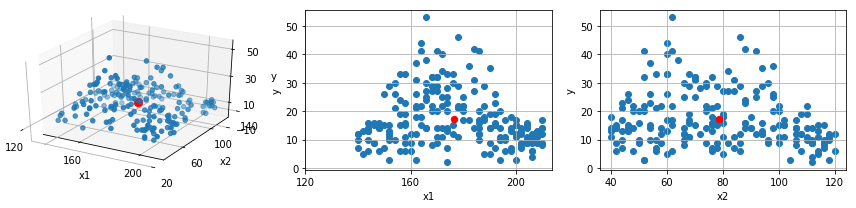

In [7]:
# Array of 200 observations {x_n, y_n} with x_n = [x_n_1, x_n_2]
training_ridge = np.loadtxt('TrainingRidge.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
plot_ridge(training_ridge)
# Array of 1476 combinations for [x_n_1, x_n_2] (36 x 41 grid) in same format
validation_ridge = np.loadtxt('ValidationRidge-Y.csv', skiprows=1, dtype=bytes, delimiter=',').astype(np.float64)
# data2 = Matrix(np.cov([[S(x1), S(x2), S(y)] for x1, x2, y in (training_ridge - training_ridge.mean(axis=0))]))

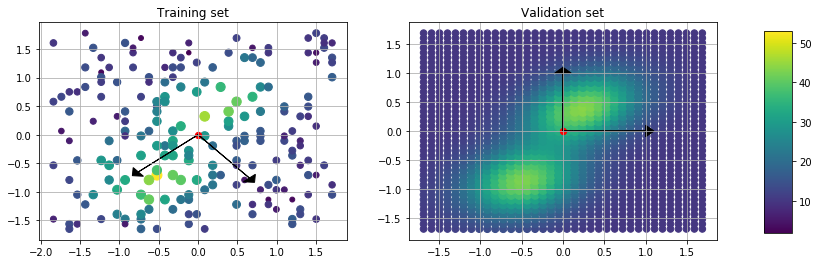

In [8]:
# Exercise 2 (a)
def whiten_data(ridge):
    ridge = np.copy(ridge)
    data = ridge[:, :2]
    # Centering
    data -= data.mean(axis=0)
    C = data.T.dot(data) / data.shape[0]
    w, V = np.linalg.eigh(C)
    L = np.diag(np.nan_to_num(1 / np.sqrt(w)))
    # Decorrelation
    data = V.T.dot(data.T).T
    # Whitening
    data = L.dot(V.T).dot(data.T).T
    ridge[:, :2] = data
    return ridge

training_whiten = whiten_data(training_ridge)
validation_whiten = whiten_data(validation_ridge)
scatter_set(training_whiten, validation_whiten)

#FIXME: Training & validation set should look rotated (decorrelation missing?)

0 [<matplotlib.axes._subplots.AxesSubplot object at 0x110a0d090>
1 [<matplotlib.axes._subplots.AxesSubplot object at 0x10eb59a90>
2 [<matplotlib.axes._subplots.AxesSubplot object at 0x119517490>
3 [<matplotlib.axes._subplots.AxesSubplot object at 0x118ed2250>
4 [<matplotlib.axes._subplots.AxesSubplot object at 0x11a5f8a90>


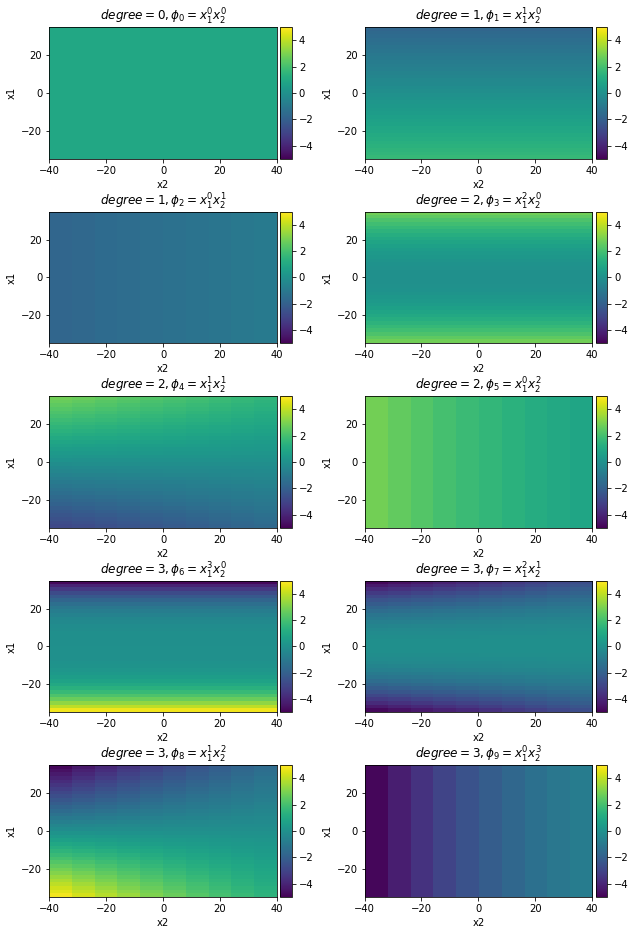

In [11]:
# Exercise 5.2 (b)
def monomial_matrix(ridge):
    def monomials(x1, x2, max_degree):
        for degree in range(max_degree + 1):
            for i in range(degree + 1):
                yield x1**(degree - i) * x2**i
    matrix = np.array([[x1, x2, monomials(x1, x2, 3), y] for x1, x2, y in ridge])
    matrix = np.array([list(x) for x in matrix[:, 2]])
    return matrix

validation_monomial = monomial_matrix(validation_whiten)
training_monomial = monomial_matrix(training_whiten).T
plot_heatmaps(validation_monomial.T.reshape(10, 41, 36))

c:\python\python35\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in sqrt


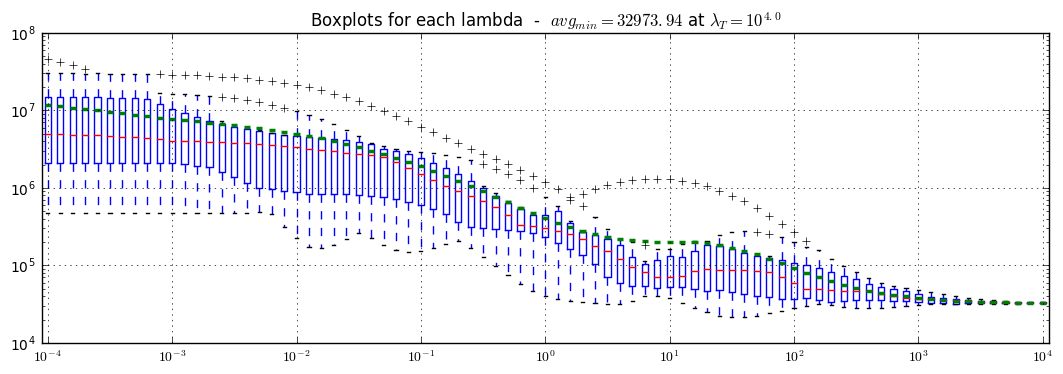

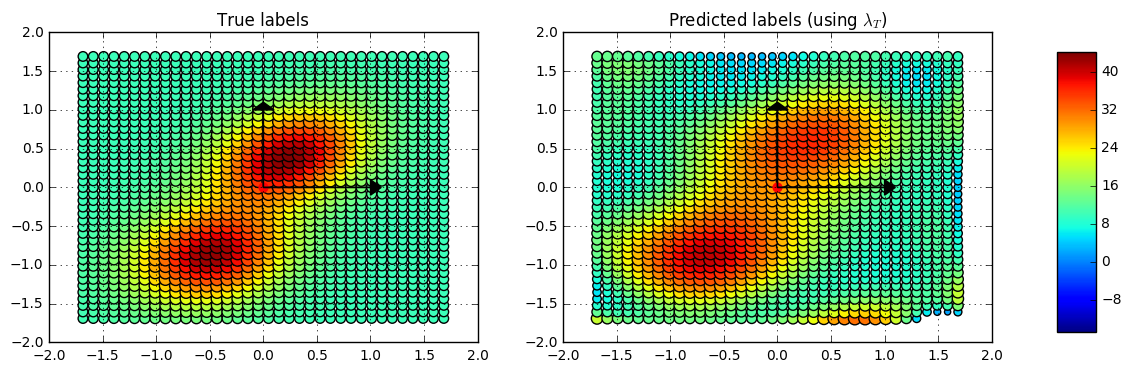

In [9]:
# Exercise 2 (c)
def weight_prediction(X, Y, lambda_):
    # Prediction function for the weight matrix using a weight decay term
    w = np.linalg.inv(X.dot(X.T) + lambda_ * np.identity(X.shape[0])).dot(X).dot(Y)
    YT = w.T.dot(X)
    return YT, w

lambdas = 10**np.linspace(-4, 4, 81)
foldSize = 20
# 10-fold cross validation with training set (training_whiten) over all lambdas
MSE = np.zeros((len(lambdas), 10))
for j, lambda_ in enumerate(lambdas):
    for i in range(10):
        train_X = training_monomial[:, foldSize*i:foldSize*(i+1)]  # (55 x 20)
        train_Y = training_ridge[foldSize*i:foldSize*(i+1), 2]  # (20 x 1)
        test_X = np.concatenate([
            training_monomial[:, :foldSize*i].T,
            training_monomial[:, foldSize*(i+1):].T,
        ]).T  # (55 x 180)
        test_Y = np.concatenate([
            training_ridge[:foldSize*i, 2],
            training_ridge[foldSize*(i+1):, 2],
        ])  # (180 x 1)
        # Regularization with weight-decay term
        _, w = weight_prediction(train_X, train_Y, lambda_)
        # Quadratic error function
        diff = w.T.dot(test_X) - test_Y
        MSE[j, i] = 0.5 * diff.dot(diff.T)
plot_mse(MSE)

# Compare predicted labels (using learned lambda) with true labels
lambdaT = lambdas[np.argmin(MSE.T.mean(axis=0))]
# FIXME: global minimum should be at 10^-1 (a bit shifted to the left), there are 2-3 local minima for the MSE
lambdaT = 10**(-1.2)
_, w = weight_prediction(training_monomial, training_ridge[:, 2], lambdaT)
YT = w.T.dot(validation_monomial.T)
prediction_set = np.array([(*x[:2], y) for x, y in zip(validation_whiten, YT)])
scatter_set(validation_whiten, prediction_set, titles=['True labels', r'Predicted labels (using $\lambda_T$)'])

In [ ]:
# Exercise 2 (e)
# Lerne lambda mit validation_set und plot wieder alles wie in 2c

# 10-fold cross validation with training set (training_whiten) over all lambdas
foldSize = 147
MSE = np.zeros((len(lambdas), 10))
for j, lambda_ in enumerate(lambdas):
    for i in range(10):
        train_X = validation_monomial[foldSize*i:foldSize*(i+1)].T  # (55 x 147)
        train_Y = validation_ridge[foldSize*i:foldSize*(i+1), 2]  # (147 x 1)
        test_X = np.concatenate([
            validation_monomial[:foldSize*i],
            validation_monomial[foldSize*(i+1):],
        ]).T
        test_Y = np.concatenate([
            validation_ridge[:foldSize*i, 2],
            validation_ridge[foldSize*(i+1):, 2],
        ])
        # Regularization with weight-decay term
        YT, w = weight_prediction(train_X, train_Y, lambda_)
        # Quadratic error function
        diff = w.T.dot(test_X) - test_Y
        MSE[j, i] = 0.5 * diff.dot(diff.T)
plot_mse(MSE, 'G')

# Compare predicted labels (using learned lambda) with true labels
lambdaG = lambdas[np.argmin(MSE.T.mean(axis=0))]
lambdaG = 0.05  # FIXME: Error in calculation for boxplot
best_YT, _ = weight_prediction(
    validation_monomial.T,
    validation_ridge[:, 2],
    lambdaG)
prediction_set = np.array([(*x[:2], y) for x, y in zip(validation_whiten, best_YT)])
scatter_set(validation_whiten, prediction_set, titles=['True labels', r'Predicted labels (using $\lambda_G$)'])